    1) 실시간 위치 인증이 맞는가?
    Users frequently 'check-in' with the app to update their current location, which is then broadcast to their friends.
    -> 실시간 위치인증 맞음. brightkite 또한 실시간 위치인증이 맞다고 함.

    2) 중분류 마치기 -> 아직 진행중. 뉴욕과 도쿄 유저에 대한 데이터셋이 별도로 있는데, 이 경우 카테고리가 보다 적어 

In [62]:
import numpy as np
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import math

In [63]:
# UTC_time 변경 함수

def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def tzo_convert(tzo_to_convert):
    return  timedelta(hours=tzo_to_convert/60)

In [64]:
nyc_filepath = 'C:/Users/piai/Desktop/code_file/dataset_WWW2019/dataset_TSMC2014_NYC.csv\dataset_TSMC2014_NYC.csv'
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")

nyc_data = pd.read_csv(nyc_filepath,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

nyc_data["utcTimestampOffset"] = nyc_data.utcTimestamp + nyc_data.timezoneOffset.apply(tzo_convert)

nyc_data["hour"] = nyc_data.utcTimestampOffset.dt.hour

# 야행성인지 체크하는 컬럼 생성. 저녁 6시부터 새벽 6시까지 활동한 POI는 야행성 Ture로 표시.
nyc_data["nightlife"] = nyc_data['hour'].apply(lambda x: 'True' if (18 <= x < 24) or (0 <= x < 6)else 'False')

# 요일이 무엇인지 0~6 순서로 설정. 월요일이 0, 일요일이 6.
nyc_data["dayofweek"] = nyc_data.utcTimestampOffset.dt.dayofweek

# 평일과 주말을 구분. 평일이면 True, 주말이면 False.
nyc_data["weekday"] = nyc_data['dayofweek'].apply(lambda x: 'True' if x <= 4 else 'False')

In [65]:
# 카테고리는 251개가 존재한다.
nyc_data['venueCategory'].drop_duplicates().count()

251

In [66]:
nyc_data['venueCategory'].drop_duplicates()

0         Arts & Crafts Store
1                      Bridge
2              Home (private)
3              Medical Center
4                  Food Truck
                 ...         
102807        Photography Lab
110352          Garden Center
139848           Music School
158923                 Castle
167530            Pet Service
Name: venueCategory, Length: 251, dtype: object

<AxesSubplot:xlabel='dayofweek'>

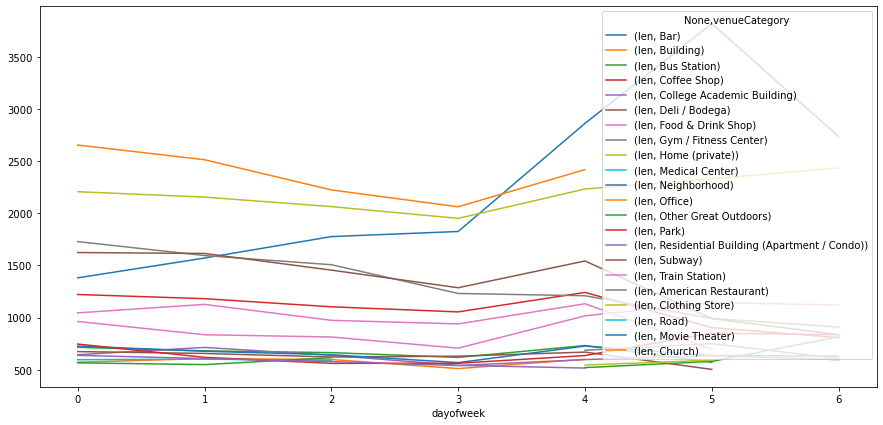

In [67]:
fig, ax = plt.subplots(figsize=(15,7))
pru= nyc_data.groupby([ 'dayofweek','venueCategory']).venueId.agg([len])
pru2 =pru.query('len > 500')
pru2.unstack().plot(ax=ax)

In [68]:
pru.sort_values(['len'], ascending= False).head(60)

,,len
dayofweek,venueCategory,
5,Bar,3822
4,Bar,2864
6,Bar,2737
0,Office,2656
1,Office,2515
6,Home (private),2436
4,Office,2420
5,Home (private),2331
4,Home (private),2234


<AxesSubplot:>

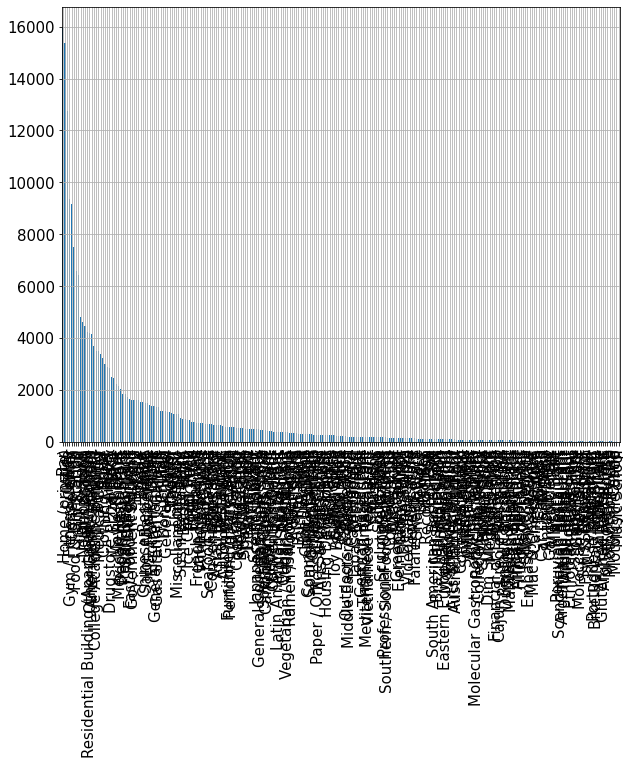

In [69]:
CountStatus = pd.value_counts(nyc_data['venueCategory'], sort=True)
CountStatus.plot.bar()
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15)  # figsize, fontsize 조정

In [70]:
nyc_data.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25,2012-04-03 14:00:25,14,False,1,True
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24,2012-04-03 14:02:24,14,False,1,True
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,2012-04-03 18:02:41,2012-04-03 14:02:41,14,False,1,True
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,2012-04-03 18:03:00,2012-04-03 14:03:00,14,False,1,True


In [71]:
len(nyc_data['userId'].unique())

1083

In [72]:
len(nyc_data['venueCategory'].unique())

251

In [73]:
# 유저 아이디 별로 정렬 후
# 유저 아이디 행 수만큼만 len 돌려서 time delta 하고,
# 이대로 컬럼 하나 추가하기.
nyc_data_sorted = nyc_data.sort_values(by=['userId', 'utcTimestampOffset'], ascending=[True, True])

In [74]:
nyc_data_sorted.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday
2454,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True
3660,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False
5603,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False
5783,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False
6696,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True


In [75]:
nyc_data_sorted.reset_index(inplace= True, drop= True)
#nyc_data_sorted.drop(['index'], axis=1, inplace= True)

In [76]:
# for i in range(len(nyc_data_sorted) -1):
#    if i == len(nyc_data_sorted) - 1:
#        continue
#    if nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i+1, "userId"]:
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
#        nyc_data_sorted.loc[i+1, 'time_diff'] = pd.to_timedelta(0, unit='h')
#    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, "userId"] = nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
# nyc_data_sorted.loc[len(nyc_data_sorted)-1,'time_diff'] = pd.to_timedelta(0, unit='h')

In [77]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)

In [78]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02
227424,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19
227425,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11
227426,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44


In [79]:
# nyc_data_sorted.info()

In [80]:
# !!!!!!!!!!오해의 소지가 있는 poi 중복값 제거를 위해 카테고리 값 수정 작업 코드!!!!!!!!!!!!!
nyc_data_sorted.replace('Sushi Restaurant', 'Japanese Restaurant', inplace= True)

In [81]:
import datetime

nyc_data_sorted['duplicate'] = False
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [82]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        continue
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
        nyc_data_sorted.loc[i-1, 'time_diff'] = pd.to_timedelta(0, unit='h')

In [83]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227423,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,False,29.033333
227424,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,False,8329.316667
227425,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,False,817.183333
227426,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44,False,4474.733333


In [84]:
# 이 사용자는 저녁만 되면 먹고 논다. 여러번 중복해서 장소인증을 하는 듯 함.
nyc_data_sorted[nyc_data_sorted['userId'] == 470].sort_values('utcTimestampOffset').head(10)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
101424,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True,0 days 05:36:25,False,336.416667
101425,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True,0 days 00:10:12,False,10.200000
101426,470,4be09b7fcb81c9b62069668b,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.624513,-73.965070,-240,2012-04-03 23:46:46,2012-04-03 19:46:46,19,True,1,True,0 days 00:00:30,True,0.500000
101427,470,49f50c9ff964a5208a6b1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.677611,-73.963748,-240,2012-04-03 23:47:16,2012-04-03 19:47:16,19,True,1,True,0 days 00:00:33,True,0.550000
101428,470,4a6a09b1f964a52071cc1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.702752,-73.990696,-240,2012-04-03 23:47:49,2012-04-03 19:47:49,19,True,1,True,0 days 00:00:26,True,0.433333
101429,470,49e63b62f964a52027641fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.687583,-73.989895,-240,2012-04-03 23:48:15,2012-04-03 19:48:15,19,True,1,True,0 days 00:00:36,True,0.600000
101430,470,45795395f964a520d23e1fe3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.679694,-73.974252,-240,2012-04-03 23:48:51,2012-04-03 19:48:51,19,True,1,True,0 days 00:02:42,True,2.700000
101431,470,4c9d89017ada199cf0a493bc,4bf58dd8d48988d111941735,Japanese Restaurant,40.705436,-74.008348,-240,2012-04-03 23:51:33,2012-04-03 19:51:33,19,True,1,True,0 days 00:00:28,True,0.466667
101432,470,4b5b92def964a5201d0829e3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.599278,-73.990891,-240,2012-04-03 23:52:01,2012-04-03 19:52:01,19,True,1,True,0 days 00:00:24,True,0.400000
101433,470,4baea553f964a5206dca3be3,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.657351,-73.956644,-240,2012-04-03 23:52:25,2012-04-03 19:52:25,19,True,1,True,0 days 00:07:57,True,7.950000


In [57]:
nyc_data_sorted[nyc_data_sorted['userId'] == 41].sort_values('utcTimestampOffset').head(20)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
7370,41,4b23fa86f964a520435e24e3,4bf58dd8d48988d1a7941735,College Academic Building,40.683525,-73.978754,-240,2012-06-06 18:00:52,2012-06-06 14:00:52,14,False,2,True,0 days,False,1137.583333
7371,41,4b942cf1f964a520d86c34e3,4bf58dd8d48988d171941735,Event Space,40.817514,-73.955083,-240,2012-06-07 12:58:27,2012-06-07 08:58:27,8,False,3,True,0 days,False,1403.916667
7372,41,4b942cf1f964a520d86c34e3,4bf58dd8d48988d171941735,Event Space,40.817514,-73.955083,-240,2012-06-08 12:22:22,2012-06-08 08:22:22,8,False,4,True,0 days,False,1979.666667
7373,41,4dd91263ae60680f152e754a,4bf58dd8d48988d163941735,Park,40.661168,-73.979069,-240,2012-06-09 21:22:02,2012-06-09 17:22:02,17,False,5,False,0 days,False,306.483333
7374,41,4fd40649e4b034e1fa5b729a,4bf58dd8d48988d103941735,Home (private),40.602590,-73.988880,-240,2012-06-10 02:28:31,2012-06-09 22:28:31,22,True,5,False,0 days,False,1202.883333
7375,41,4bfdb176b68d0f478e30e957,4bf58dd8d48988d1fc941735,Laundry Service,40.606173,-73.986294,-240,2012-06-10 22:31:24,2012-06-10 18:31:24,18,True,6,False,0 days,False,1199.900000
7376,41,4cab3fc476d3a09333712a6b,4bf58dd8d48988d13b941735,School,40.665677,-73.917712,-240,2012-06-11 18:31:18,2012-06-11 14:31:18,14,False,0,True,0 days,False,42.600000
7377,41,4c97ee347b9d37049703da85,4bf58dd8d48988d13d941735,High School,40.764334,-73.957849,-240,2012-06-11 19:13:54,2012-06-11 15:13:54,15,False,0,True,0 days,False,243.850000
7378,41,4fd40649e4b034e1fa5b729a,4bf58dd8d48988d103941735,Home (private),40.602590,-73.988880,-240,2012-06-11 23:17:45,2012-06-11 19:17:45,19,True,0,True,0 days,False,5193.383333
7379,41,4a00fcfcf964a520cb701fe3,4bf58dd8d48988d147941735,Diner,40.669544,-73.986007,-240,2012-06-15 13:51:08,2012-06-15 09:51:08,9,False,4,True,0 days,False,2368.300000


In [58]:
nyc_data_sorted[nyc_data_sorted['userId'] == 688].sort_values('utcTimestampOffset').head(20)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
145995,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-03 20:08:04,2012-04-03 16:08:04,16,False,1,True,0 days,False,884.416667
145996,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-04 10:52:29,2012-04-04 06:52:29,6,False,2,True,0 days,False,1441.233333
145997,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-05 10:53:43,2012-04-05 06:53:43,6,False,3,True,0 days,False,3029.183333
145998,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 13:22:54,2012-04-07 09:22:54,9,False,5,False,0 days,False,269.833333
145999,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-07 17:52:44,2012-04-07 13:52:44,13,False,5,False,0 days,False,122.866667
146000,688,4b696ecdf964a5201fa22be3,4bf58dd8d48988d175941735,Gym / Fitness Center,40.741096,-73.992705,-240,2012-04-07 19:55:36,2012-04-07 15:55:36,15,False,5,False,0 days,False,226.333333
146001,688,427c0500f964a52099211fe3,4bf58dd8d48988d1df931735,BBQ Joint,40.744378,-73.996205,-240,2012-04-07 23:41:56,2012-04-07 19:41:56,19,True,5,False,0 days,False,168.700000
146002,688,4123ed80f964a5203b0c1fe3,4bf58dd8d48988d116941735,Bar,40.744525,-73.990908,-240,2012-04-08 02:30:38,2012-04-07 22:30:38,22,True,5,False,0 days,False,57.800000
146003,688,4aa936ecf964a520815220e3,4bf58dd8d48988d11f941735,Bar,40.744541,-73.990595,-240,2012-04-08 03:28:26,2012-04-07 23:28:26,23,True,5,False,0 days,False,563.200000
146004,688,4cdc8c7699026dcb4a0c1481,4bf58dd8d48988d175941735,Gym / Fitness Center,40.744047,-73.984027,-240,2012-04-08 12:51:38,2012-04-08 08:51:38,8,False,6,False,0 days,False,1828.183333


In [59]:
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [25]:
nyc_data_sorted.head(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
5,1,3fd66200f964a52094e41ee3,4bf58dd8d48988d1cc941735,Steakhouse,40.734276,-73.993525,-240,2012-04-10 00:24:31,2012-04-09 20:24:31,20,True,0,True,0 days 03:12:25,False,192.416667
6,1,42586c80f964a520db201fe3,4bf58dd8d48988d121941735,Bar,40.775986,-73.979528,-240,2012-04-10 03:36:56,2012-04-09 23:36:56,23,True,0,True,0 days 12:44:52,False,764.866667
7,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-10 16:21:48,2012-04-10 12:21:48,12,False,1,True,2 days 00:57:33,False,2937.550000
8,1,49d2b43ef964a520cb5b1fe3,4bf58dd8d48988d1e0931735,Coffee Shop,40.720087,-74.003961,-240,2012-04-12 17:19:21,2012-04-12 13:19:21,13,False,3,True,0 days 22:22:20,False,1342.333333
9,1,4f3283f0e4b057434d8fdc81,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.717888,-74.005668,-240,2012-04-13 15:41:41,2012-04-13 11:41:41,11,False,4,True,0 days 09:29:39,False,569.650000


## Timedelta를 바탕으로 현 POI와 다음 POI 간 체류시간을 계산 & 다양한 EDA 수행작업 시작

In [85]:
nyc_data_sorted[nyc_data_sorted['venueCategory'] == 'Bar'].tail(30)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
227244,1083,3fd66200f964a52057e91ee3,4bf58dd8d48988d121941735,Bar,40.729470,-73.987985,-240,2012-05-19 03:34:34,2012-05-18 23:34:34,23,True,4,True,2 days 11:01:58,False,3541.966667
227247,1083,440d6b93f964a5208b301fe3,4bf58dd8d48988d116941735,Bar,40.731987,-73.983804,-240,2012-05-24 00:48:04,2012-05-23 20:48:04,20,True,2,True,1 days 17:39:47,False,2499.783333
227251,1083,3fd66200f964a5208fe41ee3,4bf58dd8d48988d11b941735,Bar,40.725960,-73.989698,-240,2012-05-27 02:15:23,2012-05-26 22:15:23,22,True,5,False,1 days 00:09:18,False,1449.300000
227252,1083,49f68bb6f964a5204f6c1fe3,4bf58dd8d48988d116941735,Bar,40.740179,-74.005605,-240,2012-05-28 02:24:41,2012-05-27 22:24:41,22,True,6,False,0 days 15:30:28,False,930.466667
227259,1083,3fd66200f964a5206ae41ee3,4bf58dd8d48988d116941735,Bar,40.724686,-73.987884,-240,2012-06-03 00:51:19,2012-06-02 20:51:19,20,True,5,False,0 days 02:48:05,False,168.083333
227260,1083,4de3e4effa7651589f21983d,4bf58dd8d48988d11e941735,Bar,40.721488,-73.995029,-240,2012-06-03 03:39:24,2012-06-02 23:39:24,23,True,5,False,0 days 13:53:23,False,833.383333
227267,1083,3fd66200f964a52015e51ee3,4bf58dd8d48988d11b941735,Bar,40.731545,-73.982828,-240,2012-06-08 01:23:38,2012-06-07 21:23:38,21,True,3,True,0 days 13:01:30,False,781.500000
227279,1083,3fd66200f964a520c5f01ee3,4bf58dd8d48988d116941735,Bar,40.715013,-73.951464,-240,2012-06-17 05:07:12,2012-06-17 01:07:12,1,True,6,False,0 days 14:52:44,False,892.733333
227282,1083,436bf600f964a520ab291fe3,4bf58dd8d48988d116941735,Bar,40.729872,-73.980802,-240,2012-06-21 00:03:51,2012-06-20 20:03:51,20,True,2,True,0 days 15:18:36,False,918.600000
227290,1083,4f34533f754a657ca23ac8d7,4bf58dd8d48988d11d941735,Bar,40.747696,-73.994443,-240,2012-07-03 22:25:05,2012-07-03 18:25:05,18,True,1,True,0 days 06:58:28,False,418.466667


## 중복을 안 제거한 버전으로 분석

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

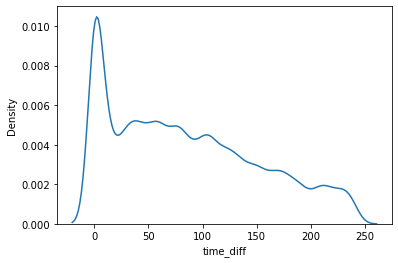

In [86]:
# Pub, Bar 등 술집 방문의 경우,
# 240분 이내(4시간 이내) 인증한 경우를 다음과 같이 분포도 확인하였다.
# 지나치게 짧은 시간은 술집 POI를 여러번 체크인(인증)하였기 때문으로 추측됨.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

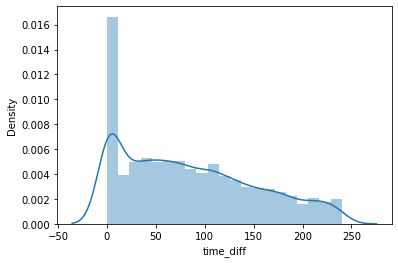

In [87]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

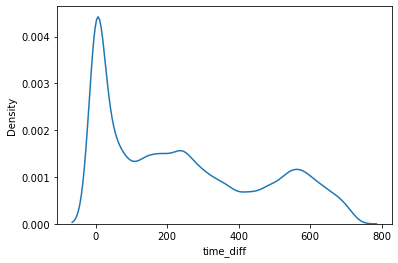

In [88]:
# Office 직장 방문의 경우,
# 720분(12시간) 이내 다른 POI를 인증한 경우를 다음과 같이 분포도 확인하였다.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

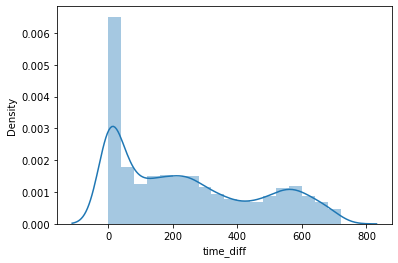

In [89]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

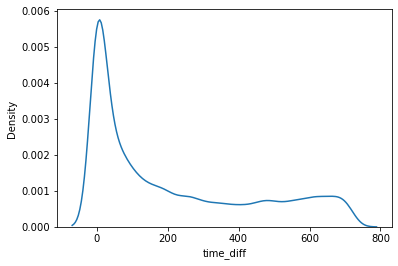

In [90]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Home'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

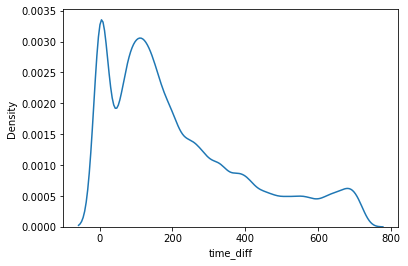

In [91]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Gym'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

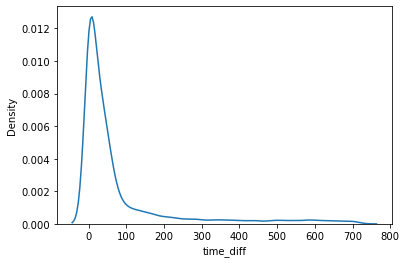

In [92]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Subway'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

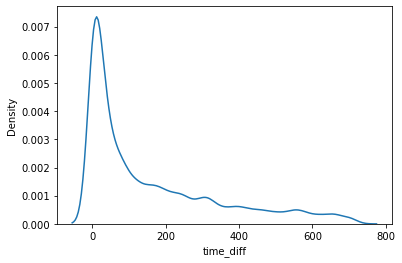

In [93]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Coffee'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

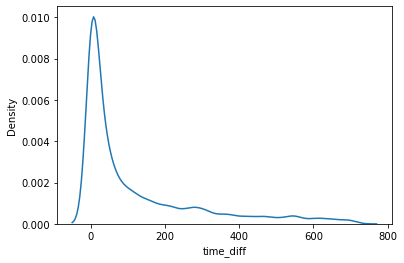

In [94]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Park'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

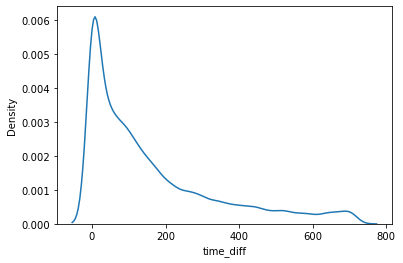

In [95]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Restaurant'))
& (nyc_data_sorted.timedelta_min < 720)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

In [96]:
(nyc_data_sorted[nyc_data_sorted['venueCategory'].str.contains('Bar')
| nyc_data_sorted['venueCategory'].str.contains('Pub')
| nyc_data_sorted['venueCategory'].str.contains('pub')]['time_diff']/datetime.timedelta(minutes=1)).head(100)

6        764.866667
10       116.600000
12       672.116667
17        67.400000
23      1013.066667
           ...     
1758     265.466667
2072     209.650000
2086     378.466667
2366      37.300000
2416     425.016667
Name: time_diff, Length: 100, dtype: float64

## 중복을 제거한 버전으로 분석

In [97]:
# 우선 중복 제거
condition = nyc_data_sorted[nyc_data_sorted['duplicate'] == True].index
nyc_data_sorted.drop(condition, inplace= True)

In [98]:
nyc_data_sorted.reset_index(inplace= True, drop= True)

In [99]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192121,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,False,29.033333
192122,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,False,8329.316667
192123,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,False,817.183333
192124,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44,False,4474.733333


In [100]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)

In [101]:
nyc_data_sorted

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
0,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,False,3970.883333
1,1,4d4ac10da0ef54814b6ffff6,4bf58dd8d48988d157941735,American Restaurant,40.784018,-73.974524,-240,2012-04-07 17:42:24,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,False,1478.083333
2,1,4db44994cda1c57c82583709,4bf58dd8d48988d1f1931735,General Entertainment,40.739398,-73.993210,-240,2012-04-08 18:20:29,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,False,101.683333
3,1,4a541923f964a52008b31fe3,4bf58dd8d48988d14e941735,American Restaurant,40.785677,-73.976498,-240,2012-04-08 20:02:10,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,False,1218.700000
4,1,40f1d480f964a5205b0a1fe3,4bf58dd8d48988d143941735,Breakfast Spot,40.719929,-74.008532,-240,2012-04-09 16:20:52,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,False,483.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192121,1083,49f4dca6f964a520626b1fe3,4bf58dd8d48988d1c1941735,Mexican Restaurant,40.735174,-73.979597,-300,2013-02-02 04:19:34,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,False,29.033333
192122,1083,40b68100f964a52085001fe3,4bf58dd8d48988d116941735,Bar,40.737831,-73.981022,-300,2013-02-02 04:48:36,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,False,8329.316667
192123,1083,4eda64ced5fb8f213a5d740e,4bf58dd8d48988d176941735,Gym / Fitness Center,40.746119,-73.993070,-300,2013-02-07 23:37:55,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,False,817.183333
192124,1083,51140198e4b0874a568cde81,4bf58dd8d48988d162941735,Other Great Outdoors,40.757790,-73.981934,-300,2013-02-08 13:15:06,2013-02-08 08:15:06,8,False,4,True,3 days 02:34:44,False,4474.733333


In [102]:
# POI 인증별 시간차 다시 update
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/datetime.timedelta(minutes=1)
nyc_data_sorted.reset_index(inplace= True, drop= True)


In [103]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'time_diff'] = pd.to_timedelta(0, unit='h')

In [104]:
nyc_data_sorted[nyc_data_sorted['userId'] == 470].sort_values('utcTimestampOffset').head(10)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
84420,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09,2012-04-03 14:00:09,14,False,1,True,0 days 05:36:25,False,336.416667
84421,470,4e08ad8cd4c03ae0b9d11f93,4bf58dd8d48988d1d2941735,Japanese Restaurant,40.683178,-73.965746,-240,2012-04-03 23:36:34,2012-04-03 19:36:34,19,True,1,True,0 days 00:42:11,False,42.183333
84422,470,4de808e8091a3279663a4303,4bf58dd8d48988d1e4931735,Bowling Alley,40.721988,-73.957536,-240,2012-04-04 00:18:45,2012-04-03 20:18:45,20,True,1,True,0 days 01:58:00,False,118.000000
84423,470,4ecb3c46f5b90c1c3318e4db,4bf58dd8d48988d1df931735,BBQ Joint,40.742965,-73.974162,-240,2012-04-04 02:16:45,2012-04-03 22:16:45,22,True,1,True,0 days 03:01:15,False,181.250000
84424,470,4baa441ff964a5201f593ae3,4bf58dd8d48988d1cb941735,Food Truck,40.757953,-73.829155,-240,2012-04-04 05:18:00,2012-04-04 01:18:00,1,True,2,True,0 days 00:29:12,False,29.200000
84425,470,4f4973f2e4b05ebee0868799,4bf58dd8d48988d1df931735,BBQ Joint,40.754239,-73.999413,-240,2012-04-04 05:47:12,2012-04-04 01:47:12,1,True,2,True,0 days 12:12:57,False,732.950000
84426,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-04 18:00:09,2012-04-04 14:00:09,14,False,2,True,0 days 14:09:58,False,849.966667
84427,470,4e4e4bb9bd4101d0d7a714cf,4bf58dd8d48988d1d3941735,Vegetarian / Vegan Restaurant,40.777224,-73.949465,-240,2012-04-05 08:10:07,2012-04-05 04:10:07,4,True,3,True,2 days 19:17:33,False,4037.550000
84428,470,4ad9f3b3f964a520431c21e3,4bf58dd8d48988d12f941735,Library,40.774338,-73.984785,-240,2012-04-08 03:27:40,2012-04-07 23:27:40,23,True,5,False,0 days 05:35:04,False,335.066667
84429,470,42dc4280f964a5203a261fe3,4bf58dd8d48988d1d3941735,Vegetarian / Vegan Restaurant,40.788608,-73.974222,-240,2012-04-08 09:02:44,2012-04-08 05:02:44,5,True,6,False,0 days 08:57:23,False,537.383333


In [105]:
nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 0]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
104,1,4ace6c89f964a52078d020e3,4bf58dd8d48988d1ed931735,Airport,40.773839,-73.871220,-300,2012-12-15 00:13:02,2012-12-14 19:13:02,19,True,4,True,0 days,False,-366329.266667
252,2,42ec1480f964a5209e261fe3,4bf58dd8d48988d1e2941735,Beach,40.567089,-73.865461,-300,2013-02-13 19:16:40,2013-02-13 14:16:40,14,False,2,True,0 days,False,-454707.000000
369,3,50f0d0bfe4b07d6a11535185,4bf58dd8d48988d1c4941735,Restaurant,40.746390,-74.000923,-300,2013-02-06 00:49:03,2013-02-05 19:49:03,19,True,1,True,0 days,False,-443639.150000
542,4,4b376908f964a520ef4025e3,4bf58dd8d48988d132941735,Church,40.816816,-73.941393,-300,2013-02-14 00:37:40,2013-02-13 19:37:40,19,True,2,True,0 days,False,-358951.016667
634,5,4e0123ec62843b639cfab90d,4bf58dd8d48988d118951735,Food & Drink Shop,40.728917,-74.041350,-300,2012-11-20 00:44:50,2012-11-19 19:44:50,19,True,0,True,0 days,False,-10947.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191230,1077,3fd66200f964a52036e31ee3,4bf58dd8d48988d16c941735,Burger Joint,40.728533,-73.987809,-300,2013-02-14 02:56:37,2013-02-13 21:56:37,21,True,2,True,0 days,False,-455355.000000
191384,1078,50780a9be4b00277f24ad107,4bf58dd8d48988d103941735,Home (private),40.782438,-74.141613,-300,2013-02-14 02:45:52,2013-02-13 21:45:52,21,True,2,True,0 days,False,-455068.883333
191514,1079,43a52546f964a520532c1fe3,4bf58dd8d48988d1ed931735,Airport,40.645089,-73.784523,-300,2012-12-17 18:26:18,2012-12-17 13:26:18,13,False,0,True,0 days,False,-367365.433333
191740,1081,4e6f6d07d22de801639a8ba2,4bf58dd8d48988d1a1941735,College Academic Building,40.721924,-73.796819,-300,2013-02-14 01:16:34,2013-02-13 20:16:34,20,True,2,True,0 days,False,-455070.733333


In [106]:
nyc_data_sorted[102:107]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min
102,1,3fd66200f964a52048e31ee3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.734895,-74.003155,-300,2012-12-14 17:55:32,2012-12-14 12:55:32,12,False,4,True,0 days 00:53:31,False,53.516667
103,1,4a8a0db0f964a520c50920e3,4bf58dd8d48988d10d951735,Record Shop,40.733022,-74.004033,-300,2012-12-14 18:49:03,2012-12-14 13:49:03,13,False,4,True,0 days 05:23:59,False,323.983333
104,1,4ace6c89f964a52078d020e3,4bf58dd8d48988d1ed931735,Airport,40.773839,-73.871220,-300,2012-12-15 00:13:02,2012-12-14 19:13:02,19,True,4,True,0 days 00:00:00,False,-366329.266667
105,2,4ef372169adf60f8399b4bd7,4bf58dd8d48988d16a941735,Bakery,40.746577,-73.981732,-240,2012-04-04 13:43:46,2012-04-04 09:43:46,9,False,2,True,0 days 01:52:23,False,112.383333
106,2,49cbb6f9f964a5200f591fe3,4bf58dd8d48988d1f6941735,Department Store,40.758315,-73.977284,-240,2012-04-04 15:36:09,2012-04-04 11:36:09,11,False,2,True,3 days 23:35:42,False,5735.700000


c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

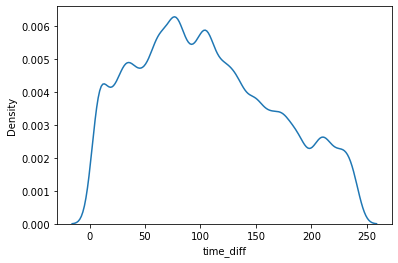

In [107]:
# Pub, Bar 등 술집 방문의 경우,
# 240분 이내(4시간 이내) 인증한 경우를 다음과 같이 분포도 확인하였다.
# 지나치게 짧은 시간은 술집 POI를 여러번 체크인(인증)하였기 때문으로 추측됨.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

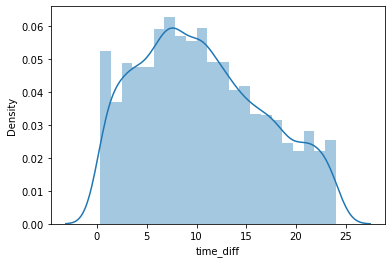

In [108]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

In [109]:
# 술집에서는 2시간 정도 체류.

nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
& (nyc_data_sorted.timedelta_min < 360) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()
# nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Bar')
# & (nyc_data_sorted.timedelta_min < 240) & (nyc_data_sorted.timedelta_min > 0)]['timedelta_min'].mean()

Timedelta('0 days 02:07:22.016210173')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

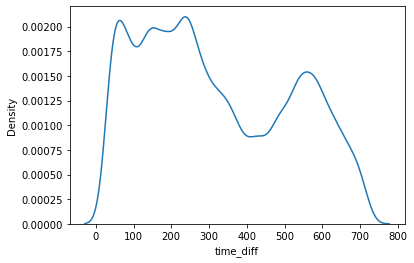

In [110]:
# Office 직장 방문의 경우,
# 720분(12시간) 이내 다른 POI를 인증한 경우를 다음과 같이 분포도를 확인하였다.
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 30)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

In [111]:
# 오피스에서는 5시간 정도 체류.
nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()

Timedelta('0 days 04:50:29.334815869')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

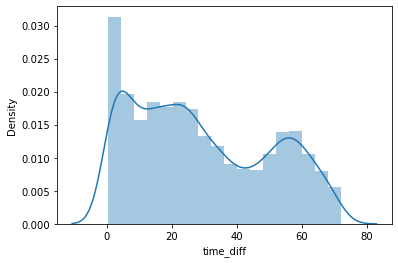

In [112]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Office')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

In [113]:
# 식당에서는 평균 2시간 체류(6시간 미만으로만 조회했으나, 12시간 미만으로 조회할 경우에는 평균이 3시간으로 증가)
nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Restaurant')
& (nyc_data_sorted.timedelta_min < 360) & (nyc_data_sorted.timedelta_min > 0)]['time_diff'].mean()

Timedelta('0 days 02:03:17.535864978')

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

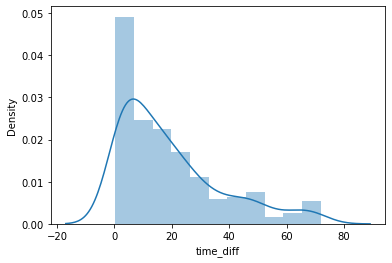

In [114]:
sns.distplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'] == 'Restaurant')
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 0)]['time_diff']/datetime.timedelta(minutes=10))

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

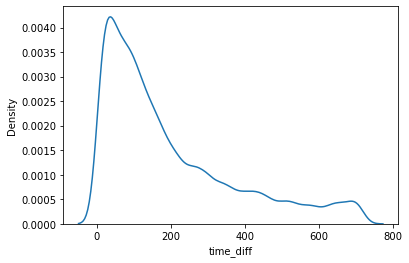

In [115]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Restaurant'))
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 5)]['time_diff']/datetime.timedelta(minutes=1), bw=0.1)

c:\Users\piai\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_diff', ylabel='Density'>

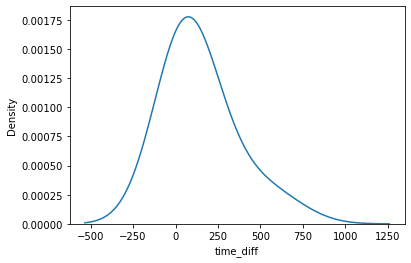

In [116]:
sns.kdeplot(nyc_data_sorted[(nyc_data_sorted['venueCategory'].str.contains('Subway'))
& (nyc_data_sorted.timedelta_min < 720) & (nyc_data_sorted.timedelta_min > 5)]['time_diff']/datetime.timedelta(minutes=1), bw=1)

In [117]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
#        nyc_data_sorted.loc[i, 'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'time_diff'] = pd.to_timedelta(0, unit='h')
        nyc_data_sorted.loc[i-1,'timedelta_min'] = 0

In [118]:
nyc_data_sorted.to_csv('refined_nyc_data.csv')

In [119]:
import pandas as pd
poi_list = pd.read_csv('C:/Users/piai/Desktop/code_file/category_list_for_categorize.txt', header = None)
poi_list.columns = ['venueCategory','Category']
poi_list.head()

,venueCategory,Category
0,Post Office,Other
1,Jazz Club,Liquid
2,Gym,Exercise
3,Indian Restaurant,Meal
4,Sandwich Place,Meal


In [120]:
poi_list

,venueCategory,Category
0,Post Office,Other
1,Jazz Club,Liquid
2,Gym,Exercise
3,Indian Restaurant,Meal
4,Sandwich Place,Meal
...,...,...
512,Comfort Food Restaurants,Meal
513,Bistros,Meal
514,Country Dance Clubs,Leisure
515,Go Kart Tracks,Leisure


In [121]:
poi_list[poi_list['Category'].isnull()]

,venueCategory,Category


In [122]:
poi_list['Category'].unique()

array(['Other', 'Liquid', 'Exercise', 'Meal', 'Entertain', 'Nightlife',
       'Shopping', 'Snack', 'Cafe', 'Leisure', 'Medical', 'Work', 'Hobby',
       'Residence', 'Hairshop', 'Station', 'School', 'Entertainment',
       'Sightseeing', 'Transportation', 'Retail', 'Event'], dtype=object)

In [123]:
poi_list[poi_list['Category'] == 'Residence']

,venueCategory,Category
87,Hotel,Residence
105,Hostel,Residence
139,Residential Building (Apartment / Condo),Residence
183,Home (private),Residence
201,College Residence Hall,Residence
228,Sorority House,Residence
296,Fraternity House,Residence
337,Motel,Residence
343,Bed & Breakfast,Residence
345,Boarding House,Residence


In [124]:
poi_list['Category'].nunique()

22

In [125]:
nyc_data_sorted['venueCategory'].nunique()

250

In [134]:
nyc_data_sorted[nyc_data_sorted['venueCategory'].str.contains('Caf')]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min,category
391,4,4a99749af964a5206a2e20e3,4bf58dd8d48988d16d941735,Cafe,40.804292,-73.948103,-240,2012-05-01 18:45:09,2012-05-01 14:45:09,14,False,1,True,0 days 04:47:55,False,287.916667,Cafe
393,4,4a99749af964a5206a2e20e3,4bf58dd8d48988d16d941735,Cafe,40.804292,-73.948103,-240,2012-05-03 17:39:39,2012-05-03 13:39:39,13,False,3,True,1 days 03:25:51,False,1645.850000,Cafe
397,4,4a99749af964a5206a2e20e3,4bf58dd8d48988d16d941735,Cafe,40.804292,-73.948103,-240,2012-05-06 00:39:10,2012-05-05 20:39:10,20,True,5,False,1 days 16:07:05,False,2407.083333,Cafe
473,4,4a99749af964a5206a2e20e3,4bf58dd8d48988d16d941735,Cafe,40.804292,-73.948103,-240,2012-08-13 23:41:47,2012-08-13 19:41:47,19,True,0,True,2 days 16:38:51,False,3878.850000,Cafe
509,4,4a99749af964a5206a2e20e3,4bf58dd8d48988d16d941735,Cafe,40.804292,-73.948103,-300,2012-12-07 22:48:35,2012-12-07 17:48:35,17,False,4,True,0 days 23:49:37,False,1429.616667,Cafe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191877,1083,4ea2c02193ad755e37150c15,4bf58dd8d48988d16d941735,Cafe,40.723096,-73.995774,-240,2012-04-14 04:11:28,2012-04-14 00:11:28,0,True,5,False,0 days 00:35:38,False,35.633333,Cafe
191884,1083,4c2a8d772219c928d24ca348,4bf58dd8d48988d16d941735,Cafe,40.745324,-73.992229,-240,2012-04-16 17:15:21,2012-04-16 13:15:21,13,False,0,True,0 days 03:26:51,False,206.850000,Cafe
191910,1083,4f7eff09e4b02164d9a1a52c,4bf58dd8d48988d16d941735,Cafe,40.746939,-73.993451,-240,2012-04-27 16:16:21,2012-04-27 12:16:21,12,False,4,True,0 days 00:28:31,False,28.516667,Cafe
191916,1083,4f7eff09e4b02164d9a1a52c,4bf58dd8d48988d16d941735,Cafe,40.746939,-73.993451,-240,2012-05-01 17:01:34,2012-05-01 13:01:34,13,False,1,True,0 days 06:07:36,False,367.600000,Cafe


In [126]:
poi_list['Category']

0         Other
1        Liquid
2      Exercise
3          Meal
4          Meal
         ...   
512        Meal
513        Meal
514     Leisure
515     Leisure
516    Shopping
Name: Category, Length: 517, dtype: object

In [132]:
nyc_data_sorted.loc[nyc_data_sorted['venueCategory'].str.contains('Caf'), 'venueCategory'] = 'Cafe'

In [135]:
nyc_data_sorted.drop(['venueId', 'venueCategoryId', 'timezoneOffset'
, 'utcTimestamp', 'category', 'duplicate'], axis= 1, inplace= True)

In [171]:
nyc_data_sorted

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
0,1,Seafood Restaurant,40.781558,-73.975792,2012-04-04 19:31:31,19,True,2,True,2 days 18:10:53,3970.883333
1,1,American Restaurant,40.784018,-73.974524,2012-04-07 13:42:24,13,False,5,False,1 days 00:38:05,1478.083333
2,1,General Entertainment,40.739398,-73.993210,2012-04-08 14:20:29,14,False,6,False,0 days 01:41:41,101.683333
3,1,American Restaurant,40.785677,-73.976498,2012-04-08 16:02:10,16,False,6,False,0 days 20:18:42,1218.700000
4,1,Breakfast Spot,40.719929,-74.008532,2012-04-09 12:20:52,12,False,0,True,0 days 08:03:39,483.650000
...,...,...,...,...,...,...,...,...,...,...,...
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667
192121,1083,Mexican Restaurant,40.735174,-73.979597,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,29.033333
192122,1083,Bar,40.737831,-73.981022,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,8329.316667
192123,1083,Gym / Fitness Center,40.746119,-73.993070,2013-02-07 18:37:55,18,True,3,True,0 days 13:37:11,817.183333


In [137]:
# 마지막 행 삭제(NaN값이 있어서 초기 한번만 수행)
nyc_data_sorted.drop(nyc_data_sorted.tail(1).index, inplace= True) # drop last n rows

In [144]:
# POI 인증 텀이 2시간(120분) 이내일 경우 학습시킬 53196개의 시퀀스 관계 행이 있다는 뜻
len(nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 120])

53196

In [145]:
# POI 인증 텀이 1시간(60분) 이내일 경우 학습시킬 35390개의 시퀀스 관계 행이 있다는 뜻!
len(nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 60])

35390

In [147]:
# POI 인증 텀이 1시간(30분) 이내일 경우 학습시킬 21838개의 시퀀스 관계 행이 있다는 뜻!
len(nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 30])

21838

In [164]:
seq_df = pd.DataFrame(columns= {'SessionId', 'latitude'
, 'longtitude', 'utcTimestampOffset', 'hour', 'nightlife', 'dayofweek', 'weekday', 'timedelta_min'})

In [179]:
seq_df = pd.DataFrame(columns= nyc_data_sorted.columns)

In [183]:
seq_df['SessionId'] = ''

In [184]:
seq_df

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId


In [186]:
index = 0
SessionId = 0
last = nyc_data_sorted.loc[len(nyc_data_sorted)-1, 'userId']
for i in range(1, last):
    tmp_df = nyc_data_sorted[nyc_data_sorted['userId'] == i]
    tmp_df_last = len(tmp_df)
    for j in range(tmp_df_last):
        if j == 0 & (tmp_df.loc[j,'timedelta_min'] < 60):
            # 첫 행이 세션의 시작이라면(다음 poi 인증이랑 시간차가 60보다 작으면) 바로 세션 아이디랑, 컬럼값들 해서 행 추가하기
            seq_df.append(nyc_data_sorted.loc[index])
        elif j == tmp_df_last - 1:
            if (tmp_df.loc[j-1, 'timedelta_min'] < 60):
                continue
                # 마지막 전 행이 막 행과 시퀀스 관계라면,
                # 마지막 행을 seq_df에 추가하고,
                # SessionId를 +1해줘서 다음 세션 채우기 시작.
            elif j == tmp_df_last - 1:
                # 마지막 행 조회했는데 추가할 세션 요소가 없다 하면 continue.
        elif ((tmp_df.loc[j-1, 'timedelta_min'] < 60) & (tmp_df.loc[j, 'timedelta_min'] < 60)):
            continue
            # 전후 timedelta_min 값이 60미만이라면, 연속되는 세션이므로 행만 추가하고 세션Id 값은 그대로.
            # 이거 아래에 넣어야 할 듯.
        elif tmp_df.loc[j-1, 'timedelta_min'] < 60:
            if tmp_df.loc[j, 'timedelta_min'] >= 60:
                continue
                # 직전 timedelta 값이 threshold보다 작은데, 현재 행은 threshold보다 크다면,
                # 세션이 끊긴 것. 현재 행을 현재 세션에 추가해주고, SessionId +1 해준다.
            else:
                continue
                # 현재 행 threshold가 작다면, 다음 행까지 세션이 이어지는 것. 다음 행 조회때 처리하라고 SessionId는 그대로 둔다.
        index += 1
    print(j)
    if i == 2:
        break

IndentationError: expected an indented block (2183156181.py, line 18)

In [199]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [206]:
seq_df = pd.DataFrame(columns= nyc_data_sorted.columns)
index = 0

for i in range(len(nyc_data_sorted)):
    if nyc_data_sorted.loc[i, 'timedelta_min'] <= 60:
        seq_df.append(list(nyc_data_sorted.loc[i]))
    if i > 100:
        break

In [205]:
list(nyc_data_sorted.loc[1])

[1,
 'American Restaurant',
 40.78401844,
 -73.97452399,
 Timestamp('2012-04-07 13:42:24'),
 13,
 'False',
 5,
 'False',
 Timedelta('1 days 00:38:05'),
 1478.0833333333333]

In [230]:
seq_df.head()

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min


In [273]:
tmp_df = nyc_data_sorted[nyc_data_sorted['timedelta_min'] < 60]

In [274]:
tmp_df.tail()

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
192042,1083,Donut Shop,40.746209,-73.994099,2012-10-08 08:50:59,8,False,0,True,0 days 00:05:33,5.550000
192058,1083,Train Station,40.750795,-73.993576,2012-11-06 09:49:02,9,False,1,True,0 days 00:18:23,18.383333
192104,1083,Clothing Store,40.749347,-73.986782,2013-01-07 19:32:35,19,True,0,True,0 days 00:39:42,39.700000
192119,1083,Bus Station,40.734500,-73.978673,2013-01-30 09:00:55,9,False,2,True,0 days 00:32:20,32.333333
192121,1083,Mexican Restaurant,40.735174,-73.979597,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,29.033333


In [275]:
nyc_data_sorted.loc[192122]

userId                               1083
venueCategory                         Bar
latitude                        40.737831
longitude                      -73.981022
utcTimestampOffset    2013-02-01 23:48:36
hour                                   23
nightlife                            True
dayofweek                               4
weekday                              True
time_diff                 5 days 18:49:19
timedelta_min                 8329.316667
Name: 192122, dtype: object

In [276]:
# tmp_df2 = pd.DataFrame(columns= nyc_data_sorted.columns)
tmp_df2 = nyc_data_sorted.loc[[(i + 1) for i in list(tmp_df.index)]]

In [277]:
tmp_df2.tail()

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
192043,1083,Office,40.745518,-73.992351,2012-10-08 08:56:32,8,False,0,True,0 days 04:17:36,257.600000
192059,1083,Office,40.745518,-73.992351,2012-11-06 10:07:25,10,False,1,True,0 days 03:05:37,185.616667
192105,1083,Gym / Fitness Center,40.746119,-73.993070,2013-01-07 20:12:17,20,True,0,True,0 days 14:14:11,854.183333
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667
192122,1083,Bar,40.737831,-73.981022,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,8329.316667


In [259]:
tmp_df2.tail(10)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
191983,1083,Bar,40.715013,-73.951464,2012-06-17 01:07:12,1,True,6,False,0 days 14:52:44,892.733333
192030,1083,Train Station,40.761861,-74.076089,2012-09-05 17:38:25,17,False,2,True,0 days 19:12:01,1152.016667
192033,1083,Furniture / Home Store,40.740019,-73.994696,2012-09-09 16:58:57,16,False,6,False,0 days 01:11:30,71.500000
192040,1083,Donut Shop,40.743072,-73.993109,2012-09-15 15:27:59,15,False,5,False,22 days 17:11:43,32711.716667
192042,1083,Donut Shop,40.746209,-73.994099,2012-10-08 08:50:59,8,False,0,True,0 days 00:05:33,5.550000
192043,1083,Office,40.745518,-73.992351,2012-10-08 08:56:32,8,False,0,True,0 days 04:17:36,257.600000
192059,1083,Office,40.745518,-73.992351,2012-11-06 10:07:25,10,False,1,True,0 days 03:05:37,185.616667
192105,1083,Gym / Fitness Center,40.746119,-73.993070,2013-01-07 20:12:17,20,True,0,True,0 days 14:14:11,854.183333
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667
192122,1083,Bar,40.737831,-73.981022,2013-02-01 23:48:36,23,True,4,True,5 days 18:49:19,8329.316667


In [278]:
tmp_df3 = pd.concat([tmp_df, tmp_df2])

In [279]:
tmp_df3.drop_duplicates().sort_values(['userId', 'utcTimestampOffset'])

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000
...,...,...,...,...,...,...,...,...,...,...,...
192105,1083,Gym / Fitness Center,40.746119,-73.993070,2013-01-07 20:12:17,20,True,0,True,0 days 14:14:11,854.183333
192119,1083,Bus Station,40.734500,-73.978673,2013-01-30 09:00:55,9,False,2,True,0 days 00:32:20,32.333333
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667
192121,1083,Mexican Restaurant,40.735174,-73.979597,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,29.033333


In [282]:
tmp_df3 = tmp_df3.sort_values(['userId', 'utcTimestampOffset'])

In [283]:
tmp_df3.tail(20)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min
191982,1083,Mexican Restaurant,40.715476,-73.944624,2012-06-17 00:11:11,0,True,6,False,0 days 00:56:01,56.016667
191983,1083,Bar,40.715013,-73.951464,2012-06-17 01:07:12,1,True,6,False,0 days 14:52:44,892.733333
192029,1083,Train Station,40.750795,-73.993576,2012-09-05 17:17:39,17,False,2,True,0 days 00:20:46,20.766667
192030,1083,Train Station,40.761861,-74.076089,2012-09-05 17:38:25,17,False,2,True,0 days 19:12:01,1152.016667
192032,1083,Cosmetics Shop,40.739084,-73.991384,2012-09-09 16:01:48,16,False,6,False,0 days 00:57:09,57.150000
192033,1083,Furniture / Home Store,40.740019,-73.994696,2012-09-09 16:58:57,16,False,6,False,0 days 01:11:30,71.500000
192039,1083,Gym / Fitness Center,40.746119,-73.993070,2012-09-15 14:40:12,14,False,5,False,0 days 00:47:47,47.783333
192040,1083,Donut Shop,40.743072,-73.993109,2012-09-15 15:27:59,15,False,5,False,22 days 17:11:43,32711.716667
192041,1083,Train Station,40.750795,-73.993576,2012-10-08 08:39:42,8,False,0,True,0 days 00:11:17,11.283333
192042,1083,Donut Shop,40.746209,-73.994099,2012-10-08 08:50:59,8,False,0,True,0 days 00:05:33,5.550000


In [284]:
# tmp_df3를 가지고 세션 데이터를 생성해보자.
tmp_df3['SessionId'] = None

In [292]:
tmp_df3.head()

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,None
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,None
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,None
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,None
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,None


In [299]:
index = 0
SessionId = 0
last = nyc_data_sorted.loc[len(nyc_data_sorted)-1, 'userId']
for i in range(len(tmp_df3)):
    tmp_df3.iloc[i, 11] = SessionId
    if tmp_df3.iloc[i, 10] >= 60:
        SessionId += 1

In [300]:
# 다음과 같이 세션을 구분한 데이터를 생성하였다(기준 시간 threshold는 60min으로, 이는 앞서서 설정을 통해 변경 가능.)
tmp_df3.head(20)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1
31,1,Music Store,40.726483,-73.984286,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,17.600000,1
31,1,Music Store,40.726483,-73.984286,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,17.600000,1
32,1,Wings Joint,40.725454,-73.987955,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,363.100000,1


In [303]:
tmp_df3.drop_duplicates(inplace=True)

In [304]:
tmp_df3.drop_duplicates().head(30)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1
31,1,Music Store,40.726483,-73.984286,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,17.600000,1
32,1,Wings Joint,40.725454,-73.987955,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,363.100000,1
38,1,Gift Shop,40.775911,-73.980051,2012-05-01 18:08:18,18,True,1,True,0 days 00:07:05,7.083333,2
39,1,Bar,40.775986,-73.979528,2012-05-01 18:15:23,18,True,1,True,3 days 16:44:32,5324.533333,2
60,1,Bar,40.721488,-73.995029,2012-05-29 19:15:10,19,True,1,True,0 days 00:35:05,35.083333,3


In [ ]:
# for i in range(1, last):
#     tmp_df = nyc_data_sorted[nyc_data_sorted['userId'] == i]
#     tmp_df_last = len(tmp_df)
#     for j in range(tmp_df_last):
#         if j == 0 & (tmp_df.loc[j,'timedelta_min'] < 60):
#             tmp_df.loc[j, 'SessionId'] = SessionId
#             print(tmp_df.loc[j])
#             # 첫 행이 세션의 시작이라면(다음 poi 인증이랑 시간차가 60보다 작으면) 바로 세션 아이디랑, 컬럼값들 해서 행 추가하기
#             seq_df.append(nyc_data_sorted.loc[index])
#             seq_df.loc[index, 'SessionId'] = SessionId
#             print(seq_df)
#         elif j == tmp_df_last - 1:
#             if (tmp_df.loc[j-1, 'timedelta_min'] < 60):
#                 continue
#                 # 마지막 전 행이 막 행과 시퀀스 관계라면,
#                 # 마지막 행을 seq_df에 추가하고,
#                 # SessionId를 +1해줘서 다음 세션 채우기 시작.
#             elif j == tmp_df_last - 1:
#                 # 마지막 행 조회했는데 추가할 세션 요소가 없다 하면 continue.
#                 continue
#     SessionId += 1

In [306]:
tmp_df3.head()

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1


In [308]:
tmp_df3.to_csv('refined_data_for_sequence_recommendataion.csv')

In [307]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [309]:
data_path = Path('C:/Users/piai/Desktop/code_file/') 
train_path = data_path / 'refined_data_for_sequence_recommendataion.csv'
train_path

WindowsPath('C:/Users/piai/Desktop/code_file/refined_data_for_sequence_recommendataion.csv')

In [318]:
len(tmp_df3)

60075

In [319]:
tmp_df3.head(3)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.96878,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.96864,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.99930,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1


In [322]:
tmp_df3[['SessionId','utcTimestampOffset','venueCategory']]

,SessionId,utcTimestampOffset,venueCategory
16,0,2012-04-14 17:24:08,Ramen / Noodle House
17,0,2012-04-14 18:07:43,Bar
28,1,2012-04-21 14:22:21,Record Shop
29,1,2012-04-21 14:48:58,Bar
30,1,2012-04-21 15:18:49,Electronics Store
...,...,...,...
192105,24682,2013-01-07 20:12:17,Gym / Fitness Center
192119,24683,2013-01-30 09:00:55,Bus Station
192120,24683,2013-01-30 09:33:15,Office
192121,24684,2013-02-01 23:19:34,Mexican Restaurant


In [316]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=1, usecols=[2, 5, 12],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['ItemId', 'Time', 'SessionId']
    return data

In [325]:
id2idx = {item_id : index for index, item_id in enumerate(tmp_df3['venueCategory'].unique())}

In [326]:
id2idx

{'Ramen /  Noodle House': 0,
 'Bar': 1,
 'Record Shop': 2,
 'Electronics Store': 3,
 'Music Store': 4,
 'Wings Joint': 5,
 'Gift Shop': 6,
 'Italian Restaurant': 7,
 'American Restaurant': 8,
 'Concert Hall': 9,
 'Flea Market': 10,
 'Beer Garden': 11,
 'Clothing Store': 12,
 'Seafood Restaurant': 13,
 'Airport': 14,
 'Steakhouse': 15,
 'Bakery': 16,
 'Home (private)': 17,
 'Deli / Bodega': 18,
 'Coffee Shop': 19,
 'Department Store': 20,
 'Cosmetics Shop': 21,
 'Food & Drink Shop': 22,
 'Bridge': 23,
 'Arts & Crafts Store': 24,
 'Subway': 25,
 'Design Studio': 26,
 'Train Station': 27,
 'Office': 28,
 'Plaza': 29,
 'Road': 30,
 'Burger Joint': 31,
 'Bus Station': 32,
 'Building': 33,
 'Park': 34,
 'Post Office': 35,
 'Sandwich Place': 36,
 'Beach': 37,
 'Other Great Outdoors': 38,
 'Mexican Restaurant': 39,
 'Hotel': 40,
 'Outdoors & Recreation': 41,
 'Gastropub': 42,
 'Neighborhood': 43,
 'Art Museum': 44,
 'Restaurant': 45,
 'Southern / Soul Food Restaurant': 46,
 'Church': 47,
 'Ban

In [327]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

In [328]:
# session length: sessionId를 공유하는 데이터 row 개수
# 해당 세션의 사용자가 그 세션동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)를 의미

session_length = data.groupby('SessionId').size()
session_length

SessionId
0        1
1        5
2        2
3        2
4        2
        ..
24680    3
24681    2
24682    2
24683    2
24684    2
Length: 24685, dtype: int64

In [329]:
session_length.min(), session_length.max()

(1, 15)

In [330]:
session_length.quantile(0.999)

10.0

In [332]:
long_session = session_length[session_length==15].index[0]
tmp_df3[tmp_df3['SessionId']==long_session]

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
10006,64,Playground,40.789091,-73.948769,2012-07-11 23:48:08,23,True,2,True,0 days 00:36:29,36.483333,1116
10007,64,American Restaurant,40.738576,-73.988328,2012-07-12 00:24:37,0,True,3,True,0 days 00:14:20,14.333333,1116
10008,64,French Restaurant,40.722705,-73.998199,2012-07-12 00:38:57,0,True,3,True,0 days 00:06:01,6.016667,1116
10009,64,Italian Restaurant,40.720073,-74.010368,2012-07-12 00:44:58,0,True,3,True,0 days 00:21:38,21.633333,1116
10010,64,Plaza,40.756490,-73.986268,2012-07-12 01:06:36,1,True,3,True,0 days 00:08:18,8.300000,1116
10011,64,Bookstore,40.754850,-73.988005,2012-07-12 01:14:54,1,True,3,True,0 days 00:12:07,12.116667,1116
10012,64,Historic Site,40.741307,-73.989358,2012-07-12 01:27:01,1,True,3,True,0 days 00:09:02,9.033333,1116
10013,64,Medical Center,40.710345,-74.005103,2012-07-12 01:36:03,1,True,3,True,0 days 00:20:32,20.533333,1116
10014,64,Art Museum,40.773614,-73.964106,2012-07-12 01:56:35,1,True,3,True,0 days 00:07:56,7.933333,1116
10015,64,College Academic Building,40.766097,-73.956478,2012-07-12 02:04:31,2,True,3,True,0 days 00:32:57,32.950000,1116


In [333]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.000041
2    0.732145
3    0.906664
4    0.960907
5    0.982621
6    0.992222
7    0.996476
8    0.998096
9    0.998906
dtype: float64

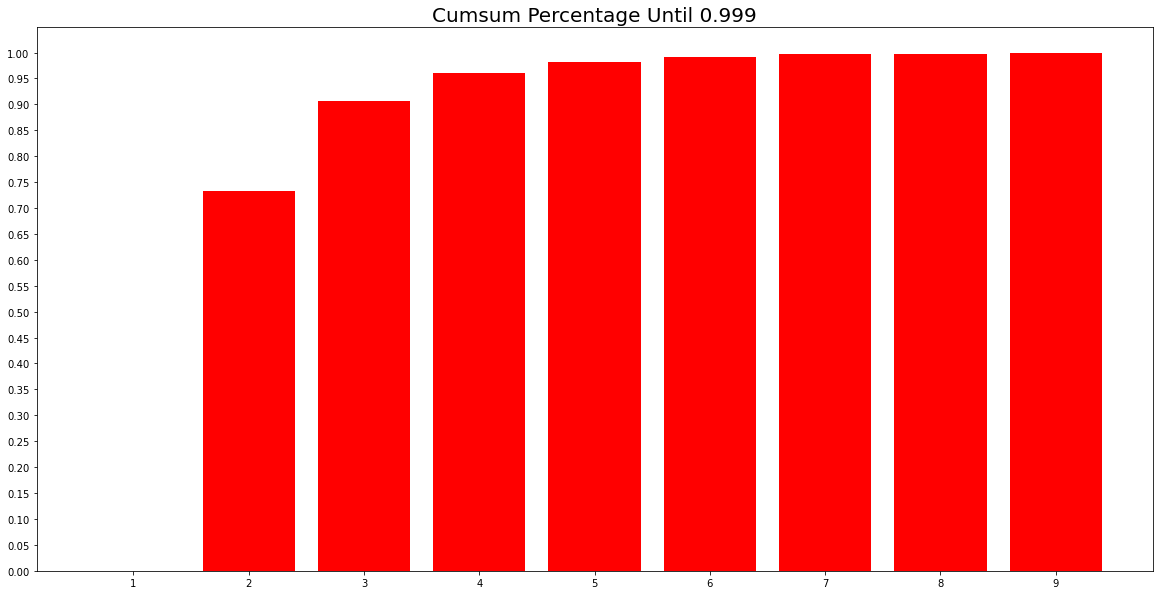

In [334]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [338]:
# Session Time: 12년 4월부터 13년 9월까지 6개월간의 데이터다.
oldest, latest = tmp_df3['utcTimestampOffset'].min(), tmp_df3['utcTimestampOffset'].max()
print(oldest) 
print(latest)

2012-04-03 14:00:09
2013-02-15 21:34:31


In [365]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거한다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('venueCategory').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['venueCategory'].isin(item_use)]
    return data

In [369]:
data = cleanse_recursive(tmp_df3, shortest=2, least_click=5)
data

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192105,1083,Gym / Fitness Center,40.746119,-73.993070,2013-01-07 20:12:17,20,True,0,True,0 days 14:14:11,854.183333,24682
192119,1083,Bus Station,40.734500,-73.978673,2013-01-30 09:00:55,9,False,2,True,0 days 00:32:20,32.333333,24683
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667,24683
192121,1083,Mexican Restaurant,40.735174,-73.979597,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,29.033333,24684


In [370]:
data.sort_values(by=['userId', 'utcTimestampOffset'], inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
data.shape

(60003, 12)

In [375]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['utcTimestampOffset'].max()
    session_last_time = data.groupby('SessionId')['utcTimestampOffset'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['venueCategory'].isin(before_date['venueCategory'])]
    return before_date, after_date

In [376]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [377]:
# timedelta: 날짜끼리의 차이를 구할 때 사용
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192105,1083,Gym / Fitness Center,40.746119,-73.993070,2013-01-07 20:12:17,20,True,0,True,0 days 14:14:11,854.183333,24682
192119,1083,Bus Station,40.734500,-73.978673,2013-01-30 09:00:55,9,False,2,True,0 days 00:32:20,32.333333,24683
192120,1083,Office,40.745518,-73.992351,2013-01-30 09:33:15,9,False,2,True,2 days 13:46:19,3706.316667,24683
192121,1083,Mexican Restaurant,40.735174,-73.979597,2013-02-01 23:19:34,23,True,4,True,0 days 00:29:02,29.033333,24684


In [357]:
# split
data_train = tmp_df3.iloc[:40019]
data_val = tmp_df3.iloc[40019:49998]
data_test = tmp_df3[49998:]

In [379]:
# data에 대한 정보를 살펴보는 함수
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["venueCategory"].nunique()}\n'
          f'\t First Time : {data["utcTimestampOffset"].min()}\n'
          f'\t Last Time : {data["utcTimestampOffset"].max()}\n')

In [380]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 59144
	 Sessions: 24298
	 Items: 228
	 First Time : 2012-04-03 14:00:09
	 Last Time : 2013-02-13 07:22:28

* valid Set Stats Info
	 Events: 765
	 Sessions: 313
	 Items: 128
	 First Time : 2012-04-03 14:03:00
	 Last Time : 2013-02-14 07:30:50

* test Set Stats Info
	 Events: 94
	 Sessions: 41
	 Items: 52
	 First Time : 2012-04-03 14:06:18
	 Last Time : 2013-02-15 21:34:31



In [382]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱함.
id2idx = {item_id : index for index, item_id in enumerate(tr['venueCategory'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['venueCategory'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [383]:
save_path = data_path / 'nyc_poi_processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [384]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()     # 각 세션이 시작된 인덱스를 가진 변수
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId
    
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [385]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId,item_idx
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0,1
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1,2
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1,3
31,1,Music Store,40.726483,-73.984286,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,17.600000,1,4
32,1,Wings Joint,40.725454,-73.987955,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,363.100000,1,5
38,1,Gift Shop,40.775911,-73.980051,2012-05-01 18:08:18,18,True,1,True,0 days 00:07:05,7.083333,2,6
39,1,Bar,40.775986,-73.979528,2012-05-01 18:15:23,18,True,1,True,3 days 16:44:32,5324.533333,2,1
60,1,Bar,40.721488,-73.995029,2012-05-29 19:15:10,19,True,1,True,0 days 00:35:05,35.083333,3,1


In [408]:
tr_dataset.df['item_idx'].nunique()

228

In [387]:
# Session DataLoader

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [388]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,userId,venueCategory,latitude,longitude,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,timedelta_min,SessionId,item_idx
16,1,Ramen / Noodle House,40.757197,-73.968780,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,43.583333,0,0
17,1,Bar,40.757305,-73.968640,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,67.400000,0,1
28,1,Record Shop,40.728912,-73.999300,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,26.616667,1,2
29,1,Bar,40.729658,-73.998515,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,29.850000,1,1
30,1,Electronics Store,40.726034,-73.996309,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,41.900000,1,3
31,1,Music Store,40.726483,-73.984286,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,17.600000,1,4
32,1,Wings Joint,40.725454,-73.987955,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,363.100000,1,5
38,1,Gift Shop,40.775911,-73.980051,2012-05-01 18:08:18,18,True,1,True,0 days 00:07:05,7.083333,2,6
39,1,Bar,40.775986,-73.979528,2012-05-01 18:15:23,18,True,1,True,3 days 16:44:32,5324.533333,2,1
60,1,Bar,40.721488,-73.995029,2012-05-29 19:15:10,19,True,1,True,0 days 00:35:05,35.083333,3,1


In [389]:
iter_ex = iter(tr_data_loader)

In [390]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 2 6 1]
Label Item Idx are :       [1 1 1 7]
Previous Masked Input Idx are []


In [391]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [392]:
# Model Architecture

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [393]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [399]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['venueCategory'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [400]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(2048, 1, 228)]          0         
                                                                 
 GRU (GRU)                   [(2048, 50),              42000     
                              (2048, 50)]                        
                                                                 
 dropout_2 (Dropout)         (2048, 50)                0         
                                                                 
 dense_2 (Dense)             (2048, 228)               11628     
                                                                 
Total params: 53,628
Trainable params: 53,628
Non-trainable params: 0
_________________________________________________________________


In [404]:
# Model Training

# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [415]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:  94%|█████████▍| 16/17 [00:00<00:00, 35.95it/s, accuracy=0.0474, train_loss=5.02]
Evaluation: 0it [00:00, ?it/s]


IndexError: index 313 is out of bounds for axis 0 with size 313

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)